### 모터스 고객등급제 개편을 위한 분석 - 1. EDA
 - 대상 : 2020~2022년 신차구매 고객 9,314명 
 - data source : 마케팅팀 김명권 대리 
 - key index = hp : 휴대폰 번호 기준으로 최근 3년간의 구매횟수, 구매금액 등 합산하였음 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')

## 한글폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rc('axes',unicode_minus=False)

In [2]:
## Data loading & Review  
df1 = pd.read_excel('data/dataset_20230609.xlsx', sheet_name='data')

print( df1.shape )
print( df1.info() )

(9314, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9314 entries, 0 to 9313
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_name        9314 non-null   object        
 1   hp                   9314 non-null   object        
 2   customer_type        9314 non-null   object        
 3   gender               8668 non-null   object        
 4   birth_day            8237 non-null   datetime64[ns]
 5   age_on_2023          8237 non-null   float64       
 6   show_room            9314 non-null   object        
 7   series               9314 non-null   object        
 8   model                9314 non-null   object        
 9   model_category       9314 non-null   object        
 10  nc_sales             9314 non-null   float64       
 11  service_sales        9314 non-null   int64         
 12  tot_sales            9314 non-null   float64       
 13  2023_sf_end          4

In [3]:
## service_sales 컬럼이 정수로 인식되어 있음. 실수형으로 변경 
## 날짜 데이터를 다루기 편하도록 연월 형태로 변경 
df1 = df1.astype({'service_sales':'float64'})
print(df1['service_sales'].dtypes)

df1['birth_day_mm'] = df1['birth_day'].dt.strftime('%Y-%m')
df1['sf_due_date_mm'] = df1['sf_due_date'].dt.strftime('%Y-%m')
df1['sf_real_end_date_mm'] = df1['sf_real_end_date'].dt.strftime('%Y-%m')

df1.head(2)

float64


,customer_name,hp,customer_type,gender,birth_day,age_on_2023,show_room,series,model,model_category,...,sf_real_end_date,sf_early_end_months,sf_early_end_yn,nc_purchase_count,service_count,nps_score,nps_category,birth_day_mm,sf_due_date_mm,sf_real_end_date_mm
0,이수진,010-4521-3503,개인,female,1978-04-16,46.0,청주,XSERIES,X4 xDrive 20d,X4,...,NaT,NaN,NaN,1,1,NaN,NaN,1978-04,NaN,NaN
1,주식회사 진사나글로벌(백희숙),010-3417-5333,법인,female,NaT,NaN,동탄,5SERIES,520d xDrive,520d,...,NaT,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN


---
### Part 1. 주요 데이터 리뷰 

<AxesSubplot:>

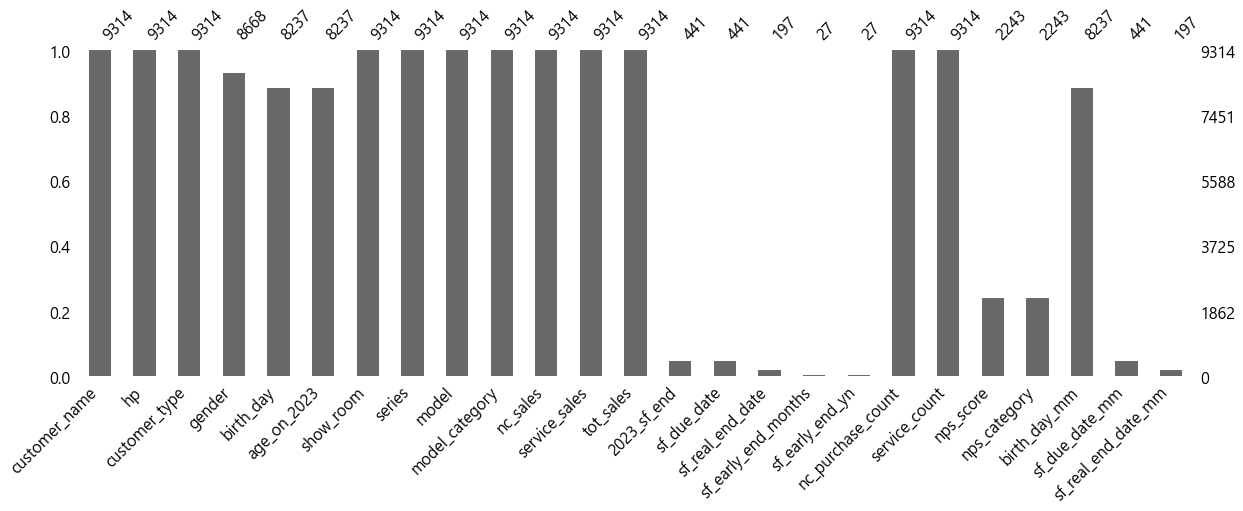

In [4]:
## N/A values 파악 
import missingno as msno
msno.bar(df1, figsize = (20,6))

- 담당자에 의한 정제작업을 거친 바, 데이터 자체의 품질은 우수한 편 (주요한 컬럼들에서 NA는 거의 없음) 
- 성별과 생일 정보가 없는 것을 법인으로 볼수 있는데, 법인 비중이 대략 10% 수준으로 보임 
- 올해 SF 만기도래 고객수는 전체 모수중 10% 이하, 분석에 주요한 인자로써 사용하기는 어려워 보임
- NPS 설문에 대한 응답율은 20%가 조금 넘는 수준 --> 분석에 보조 인자로써 사용 고려  

male      6570
female    2098
Name: gender, dtype: int64


<AxesSubplot:xlabel='gender', ylabel='count'>

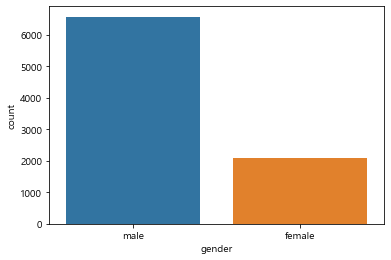

In [5]:
## 1. 고객의 성별 분포 
gender_count = df1['gender'].value_counts()
print(gender_count)

sns.countplot(data=df1, x= 'gender', order = df1['gender'].value_counts().index)

-평균연령 =  44.01541823479422
-최소연령 =  22.0
-최대연령 =  85.0
-Stdev =  9.560075931978838


[Text(0.5, 1.0, 'B.plot of Age')]

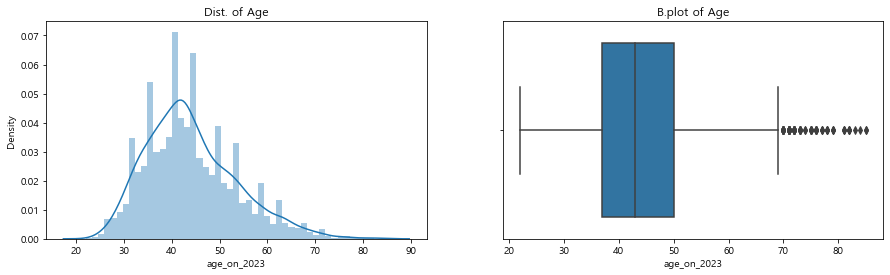

In [6]:
## 2. 고객의 연령대별 분포 
print("-평균연령 = ", np.mean(df1['age_on_2023']))
print("-최소연령 = ", np.min(df1['age_on_2023']))
print("-최대연령 = ", np.max(df1['age_on_2023']))
print("-Stdev = ", np.std(df1['age_on_2023']))

figure, (ax1,ax2) = plt.subplots(ncols=2)
figure.set_size_inches(15,4)
sns.distplot(df1['age_on_2023'], ax=ax1)
sns.boxplot(df1['age_on_2023'], ax=ax2 )
ax1.set(title = 'Dist. of Age')
ax2.set(title = 'B.plot of Age')

개인    8230
법인    1084
Name: customer_type, dtype: int64


<AxesSubplot:xlabel='customer_type', ylabel='count'>

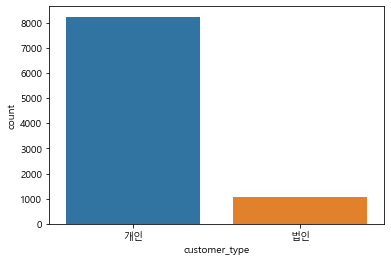

In [7]:
## 3. 개인, 법인 비중 
customer_type_cnt = df1['customer_type'].value_counts()
print(customer_type_cnt)

sns.countplot(data=df1, x= 'customer_type')

- 모터스 고객은 남성이 대부분 (남여 비율 76:24) 
- 고객 연령은 최소 22세 ~ 최대 85세로 다양하나, 35세~54세 사이가 전체의 약 70% 차지 (average = 44세)
- 개인과 법인 고객의 구성비는 약 9:1 (법인비중 11.6%). 법인고객은 고객등급 대상이 아니므로 이후 분석에서 제외함 
---

- 개인고객 구매횟수 평균 =  1.18
- 법인고객 구매횟수 평균 =  1.57
- 개인고객 누적매출액 평균 =  68400528.0
- 법인고객 누적매출액 평균 = 89647788.0


[Text(0.5, 1.0, '누적매출금액 - 법인')]

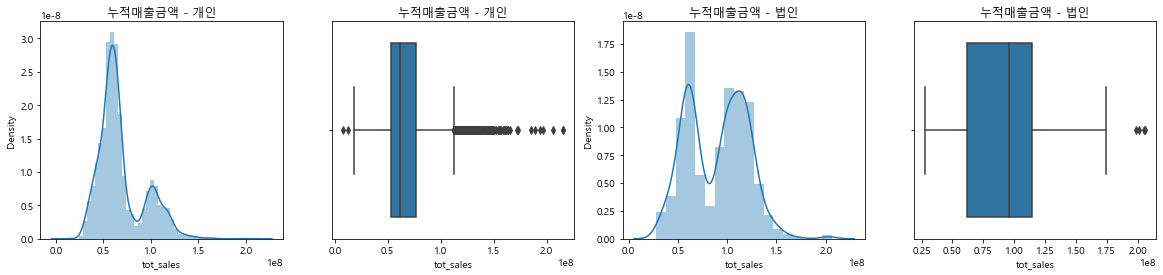

In [8]:
## 참고. 개인고객과 법인고객 구매 패턴 차이 
df_indi = df1[df1['customer_type'] == '개인']
df_corp = df1[df1['customer_type'] == '법인']

print('- 개인고객 구매횟수 평균 = ' , round(np.mean(df_indi['nc_purchase_count']), 2) )
print('- 법인고객 구매횟수 평균 = ' , round(np.mean(df_corp['nc_purchase_count']), 2) )
print('- 개인고객 누적매출액 평균 = ' , round(np.mean(df_indi['tot_sales']), 0) )
print('- 법인고객 누적매출액 평균 =' , round(np.mean(df_corp['tot_sales']), 0) )

figure, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4)
figure.set_size_inches(20,4)
sns.distplot(df_indi['tot_sales'], ax=ax1)
sns.boxplot(df_indi['tot_sales'], ax=ax2)
sns.distplot(df_corp['tot_sales'], ax=ax3)
sns.boxplot(df_corp['tot_sales'], ax=ax4)
ax1.set(title = '누적매출금액 - 개인')
ax2.set(title = '누적매출금액 - 개인')
ax3.set(title = '누적매출금액 - 법인')
ax4.set(title = '누적매출금액 - 법인')

- 법인고객은 수는 적으나 개인고객 대비 평균 2천만원 이상 더 많은 금액을 지불함 
- 또한 저렴한 차량(5시리즈?) 못지않게 1억 이상의 고가 차량 구매도 많은 것이 특징임 
--- 

XSERIES         3206
5SERIES         2579
3SERIES          934
6SERIES          470
4SERIES          272
1SERIES          239
2SERIES          201
7SERIES          191
ZSERIES           66
8SERIES           44
iNEXT SERIES      21
ISERIES            7
Name: series, dtype: int64


<AxesSubplot:xlabel='series', ylabel='count'>

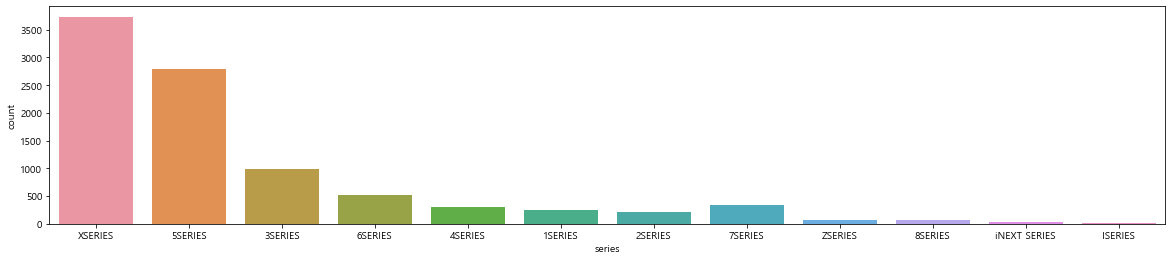

In [9]:
## 4. 차량 정보 : series 
df2 = df1[df1['customer_type'] == '개인']

series_count = df2['series'].value_counts()
print(series_count)
plt.figure(figsize = (20,4))
sns.countplot(data=df1, x= 'series', order = df2['series'].value_counts().index)

520i       1075
530i        776
X3          722
X5          628
X4          595
320i        566
X6          448
530e        417
X7          392
X1          253
523d        135
520d        120
iX3         111
3GT          96
320d         94
M340i        80
X2           57
330e         49
M550i        33
320e         23
M3           18
540i         11
M5           10
330i          8
M5(F90)       2
Name: model_category, dtype: int64


<AxesSubplot:xlabel='model_category', ylabel='count'>

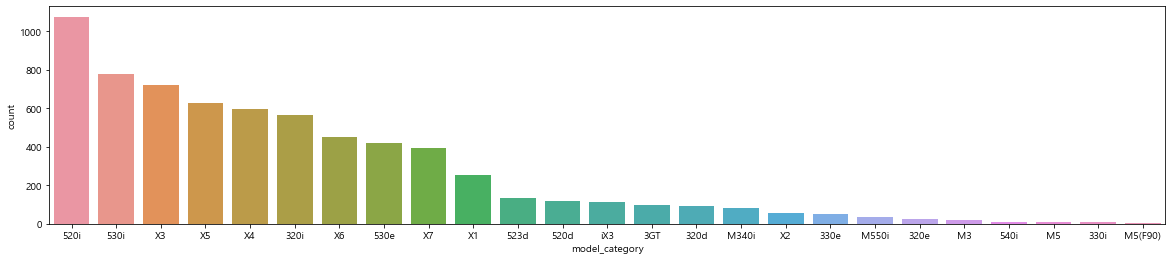

In [10]:
## 5. 차량 정보 : model
top3_series = ['XSERIES', '5SERIES', '3SERIES']
df2_top_series = df2[df2['series'].isin(top3_series)]

series_count_top_series = df2_top_series['model_category'].value_counts()
print( series_count_top_series)

plt.figure(figsize = (20,4))
sns.countplot(data=df2_top_series, x= 'model_category', order = df2_top_series['model_category'].value_counts().index)

[Text(0.5, 1.0, '선호모델 - 여성')]

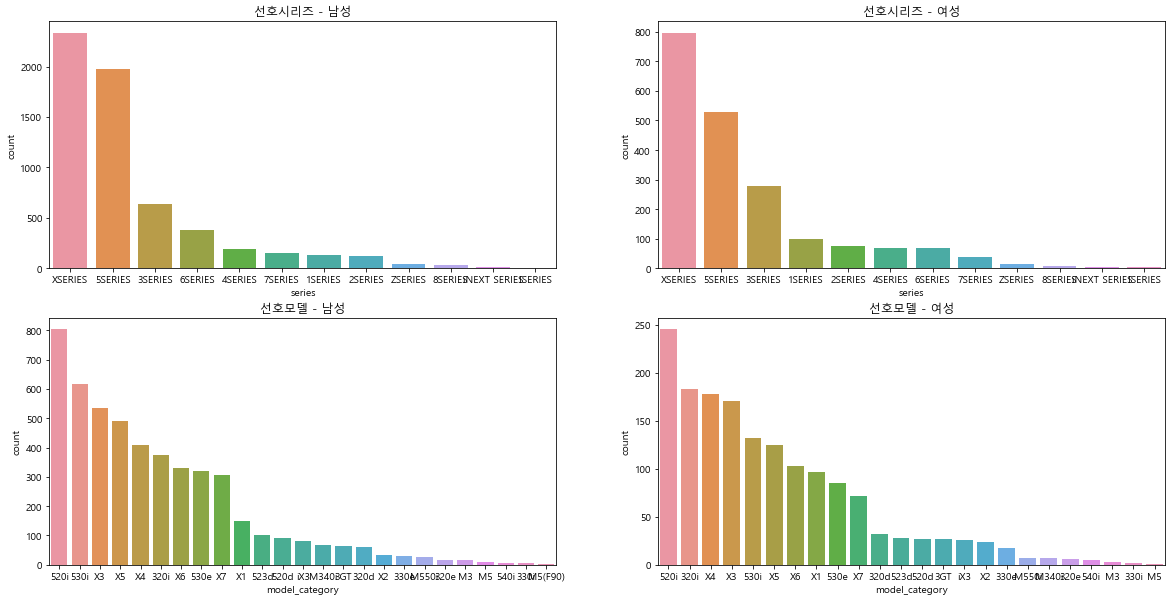

In [11]:
## 6.성별 선호 시리즈, 모델 
df2_male = df2[df2['gender'] == 'male']
df2_female = df2[df2['gender'] == 'female']
df2_top_series_male = df2_top_series[df2_top_series['gender'] == 'male']
df2_top_series_female = df2_top_series[df2_top_series['gender'] == 'female']

figure, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(20,10)
sns.countplot(data=df2_male, x= 'series', order = df2_male['series'].value_counts().index, ax=ax1)
sns.countplot(data=df2_female, x= 'series', order = df2_female['series'].value_counts().index, ax=ax2)
sns.countplot(data=df2_top_series_male, x= 'model_category', order = df2_top_series_male['model_category'].value_counts().index, ax=ax3)
sns.countplot(data=df2_top_series_female, x= 'model_category', order = df2_top_series_female['model_category'].value_counts().index, ax=ax4)

ax1.set(title = '선호시리즈 - 남성')
ax2.set(title = '선호시리즈 - 여성')
ax3.set(title = '선호모델 - 남성')
ax4.set(title = '선호모델 - 여성')

<AxesSubplot:xlabel='model_category', ylabel='count'>

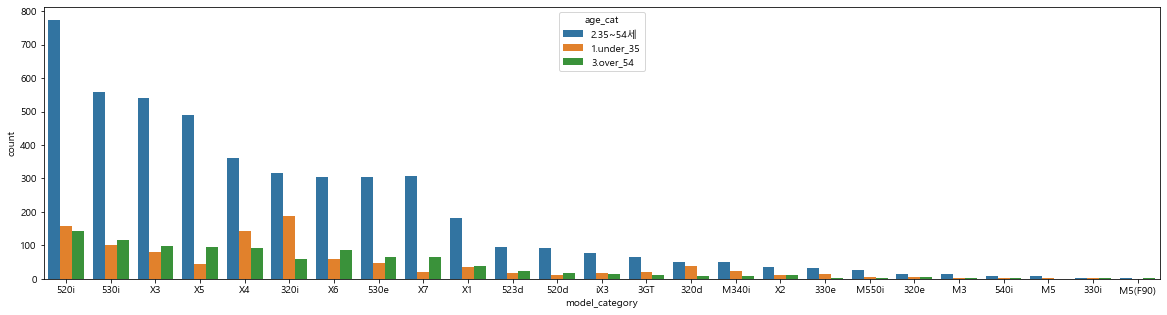

In [12]:
## 7.연령대별 선호 모델
df2_top_series['age_cat'] = '?'
df2_top_series.loc[df2_top_series["age_on_2023"] < 35, "age_cat"] = '1.under_35' 
df2_top_series.loc[(df2_top_series["age_on_2023"] >= 35)&(df2_top_series["age_on_2023"] <= 54), "age_cat"] = '2.35~54세' 
df2_top_series.loc[df2_top_series["age_on_2023"] > 54, "age_cat"] = '3.over_54' 

plt.figure(figsize = (20,5))
sns.countplot(data=df2_top_series, x= 'model_category', order = df2_top_series['model_category'].value_counts().index, hue='age_cat')

<AxesSubplot:title={'center':'Young Customer'}, xlabel='model_category', ylabel='count'>

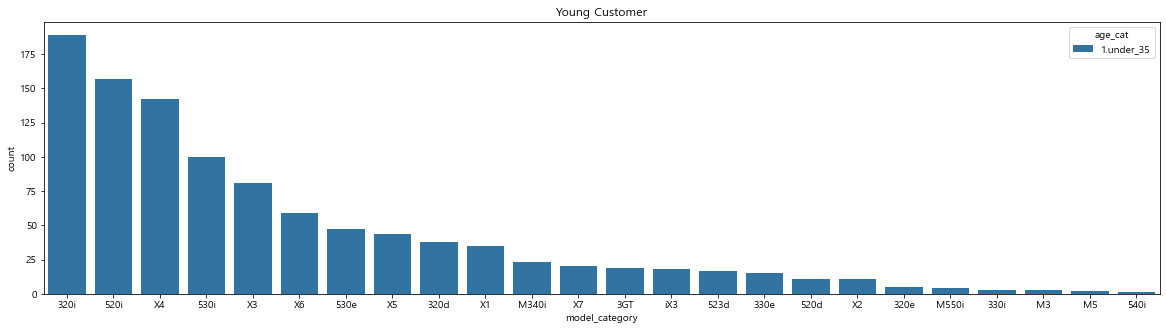

In [13]:
df2_top_series_young = df2_top_series[df2_top_series['age_cat'] == '1.under_35']
plt.figure(figsize = (20,5))
plt.title('Young Customer')
sns.countplot(data=df2_top_series_young, x= 'model_category', order = df2_top_series_young['model_category'].value_counts().index, hue='age_cat')

<AxesSubplot:title={'center':'Old Customer'}, xlabel='model_category', ylabel='count'>

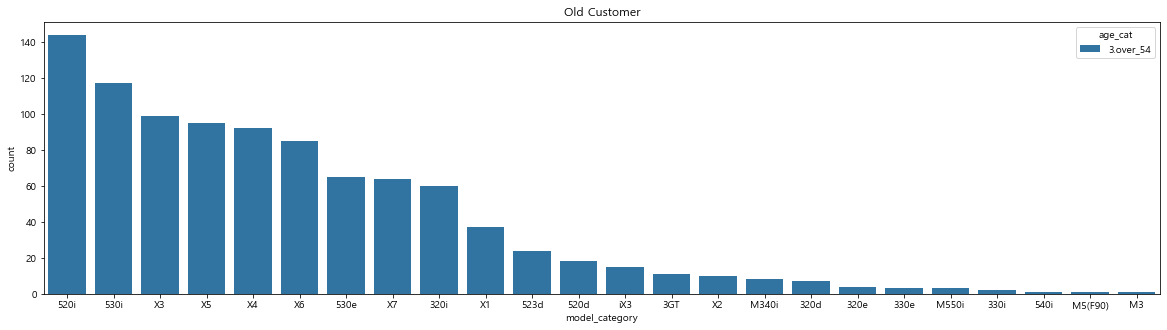

In [14]:
df2_top_series_old = df2_top_series[df2_top_series['age_cat'] == '3.over_54']
plt.figure(figsize = (20,5))
plt.title('Old Customer')
sns.countplot(data=df2_top_series_old, x= 'model_category', order = df2_top_series_old['model_category'].value_counts().index, hue='age_cat')

- 선호 시리즈/모델은 역시 대표 차종/모델인 3/5/X series & 520i/530i/x3/x5/x4 
- 여성들이 3시리즈(320i)와 쿠페형인 x4 모델에 대한 선호도가 남성대비 높은 경향 존재 (여성고객의 모수가 적어 현장과 교차검증 필요)
- 한편 35세 미만 젊은층은 320i와 x4에 대한 선호가 상대적으로 높게 나타남 (경제력 이슈? 또는 여성들의 나이가 적어서?) 
- 반면 55세 이상 고객들은 전체 대비 별다른 선호도 차이가 나타나지 않음 (30대 중반 이후로는 특정 시리즈/모델에 대한 선호도 차이가 없다?)
---

In [15]:
## 8. NC & AS sales 
print('-NC 매출 총합 = ' , round(np.sum(df2['nc_sales'], 0)))
print('-AS 매출 총합 = ' , round(np.sum(df2['service_sales'], 0)))
print('-전체매출 중 AS매출의 비중 =', np.sum(df2['service_sales'] / np.sum(df2['tot_sales'])))

print('-인당 NC 매출 평균 = ' , round(np.mean(df2['nc_sales'], 0)))
print('-인당 AS 매출 평균 = ' , round(np.mean(df2['service_sales'], 0)))

-NC 매출 총합 =  560787648664
-AS 매출 총합 =  2148697175
-전체매출 중 AS매출의 비중 = 0.0038169451855103475
-인당 NC 매출 평균 =  68139447
-인당 AS 매출 평균 =  261081


- 3개년 누적 매출액 : NC = 약 56백억원, AS = 약 21억 (AS매출의 비중은 약 0.4%) 
- 인당 평균 매출액 : NC = 약 68백만원, AS = 26만원 

[Text(0.5, 1.0, 'AS sales')]

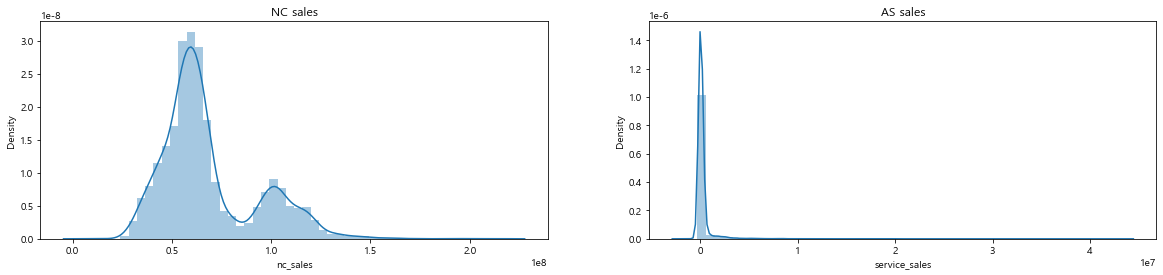

In [16]:
figure, (ax1,ax2) = plt.subplots(ncols=2)
figure.set_size_inches(20,4)
sns.distplot(df2['nc_sales'], ax=ax1)
sns.distplot(df2['service_sales'], ax=ax2)
ax1.set(title = 'NC sales')
ax2.set(title = 'AS sales')

In [17]:
## AS를 받은적이 없는 고객들이 많은 듯
df_zero_as = df2[df2['service_count'] == 0]
df_zero_as.shape

(4267, 25)

- 전체 9314명 중 4247명(45.8%)가 AS를 받은 경험 없음 

- 평균 AS 횟수(AS 1회 이상 한) =  1.2
- 최대 AS 횟수(AS 1회 이상 한) =  10
- 평균 AS 금액(AS 1회 이상 한) =  542189.5
- 최소 AS 금액(AS 1회 이상 한) =  -2209999.0
- 최대 AS 금액(AS 1회 이상 한) =  43776115.0


[Text(0.5, 1.0, 'AS 금액- AS 1회이상 한')]

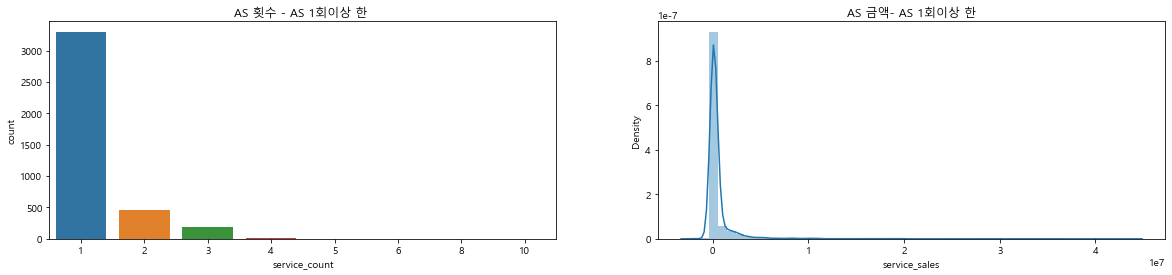

In [18]:
## 1회 이상 AS를 받은 고객만 대상으로 다시 살펴본다. 
df_ex_as = df2[df2['service_count'] >= 1]

a1 = np.mean(df_ex_as['service_count'])
a2 = np.max(df_ex_as['service_count'])
a3 = np.mean(df_ex_as['service_sales'])
a4 = np.min(df_ex_as['service_sales'])
a5 = np.max(df_ex_as['service_sales'])

print('- 평균 AS 횟수(AS 1회 이상 한) = ', round(a1,1))
print('- 최대 AS 횟수(AS 1회 이상 한) = ', round(a2,1))
print('- 평균 AS 금액(AS 1회 이상 한) = ', round(a3,1))
print('- 최소 AS 금액(AS 1회 이상 한) = ', round(a4,1))
print('- 최대 AS 금액(AS 1회 이상 한) = ', round(a5,1))

figure, (ax1,ax2) = plt.subplots(ncols=2)
figure.set_size_inches(20,4)
sns.countplot(df_ex_as['service_count'], ax=ax1)
sns.distplot(df_ex_as['service_sales'], ax=ax2)
ax1.set(title = 'AS 횟수 - AS 1회이상 한 ')
ax2.set(title = 'AS 금액- AS 1회이상 한')

- 대상기간이 3개년인바, AS 횟수는 1~2회가 대부분이나 드물게 10회까지 받은 고객도 존재
- 인당 AS매출금액의 평균은 약 54만원. 단 업의 특성상 마이너스 매출부터 최대 4000만원이 넘는 극단 값들이 존재함 

[(-1000000.0, 1000000.0)]

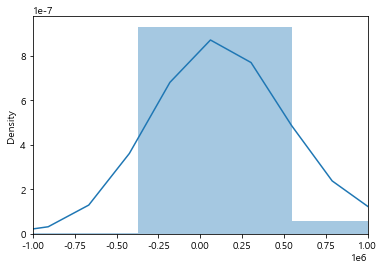

In [19]:
## x축 범위를 +/- 백만원으로 지정 
sns.distplot(x=df_ex_as['service_sales']).set(xlim=(-1000000,1000000))

- 정상적인 인당 평균 AS 금액은 100만원 이하로 보인다. 
- (검토사항) AS매출이 마이너스 이거나 지나치게 높은 경우를 어떻게 해야 하나???? 
--- 

In [20]:
## 9. 2023년 SF 만기도래 고객 
df_sf = df2[df2['2023_sf_end'] == 'Y']
print(df_sf.shape) 
df_sf_early = df_sf[df_sf['sf_early_end_yn'] == 'Y']
print(df_sf_early.shape)

(411, 25)
(23, 25)


- 당해년도 SF 만기도래 고객은 411명으로, 전체의 4.4% ( = 411/9314) 
- 또한 411명 중 중도상환하여 SF계약을 종료한 고객수는 23명으로, 5.5% ( = 23/411)
- --> 숫자가 너무 적어 더 이상 깊이있는 분석은 어려울 듯함 
----

In [21]:
## 10. NPS score
x = 9314
y = df2['nps_score'].notnull().sum()

print('- NPS 설문 응답자수 =', y)
print('- NPS 설문 응답율% =', round(y/x *100, 2) )

- NPS 설문 응답자수 = 2094
- NPS 설문 응답율% = 22.48


- NPS 평균 = 9.663801337153773
- NPS 최소 = 0.0
- NPS 최대 = 10.0


<AxesSubplot:xlabel='nps_score', ylabel='count'>

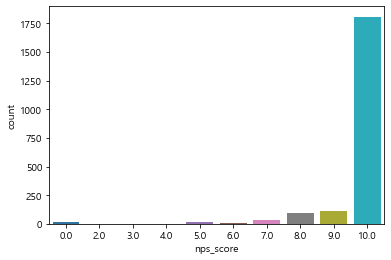

In [22]:
## 무응답이 많으므로 설문에 응답한 고객들 대상으로 분석 
## NPS는 10점 만점이며, 0~6점 : detractor / 7~8점 : passive / 9~10점 : promotor로 구분됨 
df_nps = df2[df2['nps_score'].notnull()]

print('- NPS 평균 =', np.mean(df_nps['nps_score']) )
print('- NPS 최소 =', np.min(df_nps['nps_score']) )
print('- NPS 최대 =', np.max(df_nps['nps_score']) )

#sns.distplot(df_nps['nps_score'])
sns.countplot(df_nps['nps_score'])

3.promoter     1918
2.passive       133
1.detractor      43
Name: nps_category, dtype: int64


<AxesSubplot:xlabel='nps_category', ylabel='count'>

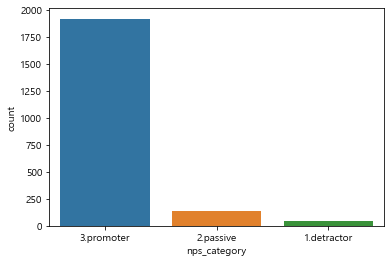

In [23]:
print( df_nps['nps_category'].value_counts() )
sns.countplot(df_nps['nps_category'])

- NPS설문에 응답한 고객수는 2094명으로 전체의 약 22.5% 
- NPS 평균 9.7점으로, 대부분의 고객들이 9~10점으로 응답 ( 1.비추천 43명(2%) / 2.중립 133명(6%) / 3. 추천 1918명(92%) )
- 고객들의 좋은 평가를 독려한 결과로 보이나, 한편 약 8%(176명)의 중립 또는 비추천 고객들도 존재함 

In [24]:
## NPS 점수를 낮게 준 고객들에게 어떤 특징이 있을까? 
## 만족도에 영향을 줄수 있을 것 같은 인자들만 추려서 새로운 데이터셋 생성 
df2_small = df2[['gender', 'age_on_2023', 'show_room', 'series', 'model_category', 'nc_sales', 'service_sales', 'tot_sales', 'nc_purchase_count', 'service_count', 'nps_score']]
df2_small.shape

(8230, 11)

In [25]:
df2_small.corr() 

,age_on_2023,nc_sales,service_sales,tot_sales,nc_purchase_count,service_count,nps_score
age_on_2023,1.000000,0.115237,-0.008065,0.114685,-0.001403,0.005412,-0.056911
nc_sales,0.115237,1.000000,-0.014744,0.998367,-0.008642,-0.012691,-0.030553
service_sales,-0.008065,-0.014744,1.000000,0.042395,0.000527,0.151136,0.017177
tot_sales,0.114685,0.998367,0.042395,1.000000,-0.008605,-0.004047,-0.029241
nc_purchase_count,-0.001403,-0.008642,0.000527,-0.008605,1.000000,0.453605,-0.000452
service_count,0.005412,-0.012691,0.151136,-0.004047,0.453605,1.000000,-0.007565
nps_score,-0.056911,-0.030553,0.017177,-0.029241,-0.000452,-0.007565,1.000000


<AxesSubplot:xlabel='age_on_2023', ylabel='nps_score'>

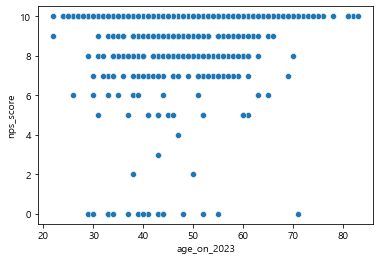

In [26]:
sns.scatterplot(data=df2_small, x= 'age_on_2023', y='nps_score')

- 숫자형 변수들과 NPS 점수간 상관관계는 보이지 않음 
- '나이(age_on_2023)'가 약간 관련이 있어 보여 확인해 봤으나, 전혀 패턴이 보이지 않았음 

[Text(0.5, 1.0, 'NPS score - 전시장별')]

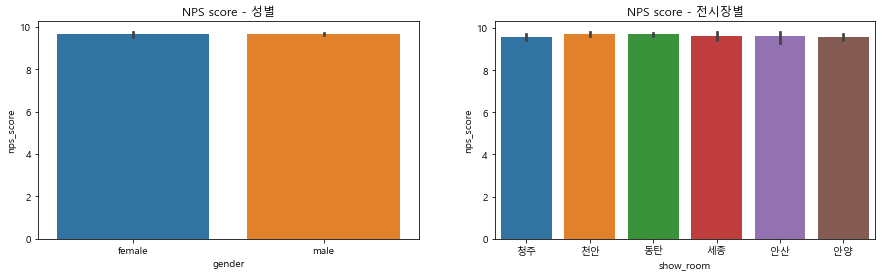

In [27]:
figure, (ax1,ax2) = plt.subplots(ncols=2)
figure.set_size_inches(15,4)
sns.barplot(data=df2_small, x= 'gender', y='nps_score', ax=ax1)
sns.barplot(data=df2_small, x= 'show_room', y='nps_score', ax=ax2)
ax1.set(title = 'NPS score - 성별')
ax2.set(title = 'NPS score - 전시장별')

<AxesSubplot:xlabel='nps_score', ylabel='series'>

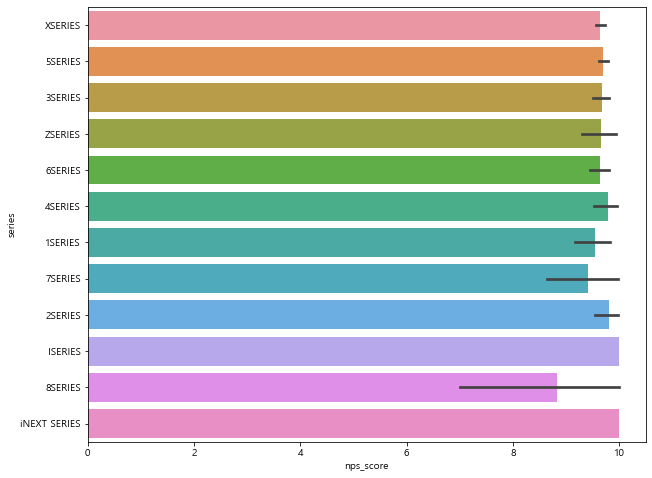

In [28]:
plt.figure(figsize = (10,8))
sns.barplot(data=df2_small, y= 'series', x='nps_score')

(191, 11)


<AxesSubplot:xlabel='nps_score', ylabel='count'>

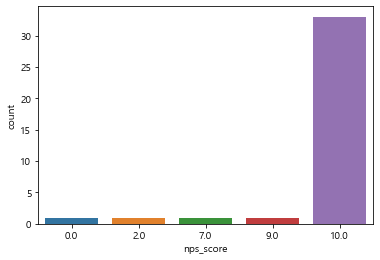

In [29]:
## 7시리즈 고객들의 NPS 
df2_small_7s = df2_small[df2_small['series']=='7SERIES']
print(df2_small_7s.shape)
sns.countplot(df2_small_7s['nps_score'])

(44, 11)


<AxesSubplot:xlabel='nps_score', ylabel='count'>

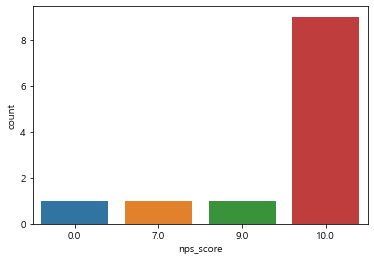

In [30]:
## 8시리즈 고객들의 NPS 
df2_small_8s = df2_small[df2_small['series']=='8SERIES']
print(df2_small_8s.shape)
sns.countplot(df2_small_8s['nps_score'])

- 성별과 전시장별로도 점수차가 나타나지 않음, 차량의 시리즈별로 보았을때 7시리즈와 8시리즈에서 다소 차이가 나타나서 더 살펴보니 ... 
- 7시리즈 191명 & 8시리즈 44명으로 모수가 적은 가운데, 한두명의 낮은 점수때문에 이러한 결과를 나타냄 
- --> 결론적으로 현재의 데이터로써는 NPS 점수와의 연관성을 찾을 수 없었음 

--- 
### [데이터 리뷰결과 정리] 
1. 모터스의 주력 고객은 35~54세 사이의 남성임. 여성은 약 25%를 차지하는데 상대적으로 3시리즈 구매가 많아 남성대비 매출액이 다소 낮게 나타남 

2. 최근 3년간 고객 1인당 평균 매출액은 약 68백만원이며, AS의 경우 전체 고객중 약 54%가 AS 입고 경험. 
   AS 경험여부와 상관없이 평균 AS매출을 산출할 경우 인당 평균 26만원 수준인데, NC매출과 AS매출의 금액단위가 워낙 다르다 보니 단순하게 합산할 경우 AS매출의 영향력은 매우 미미해 질것임. 
   고객등급 산정시 AS매출에 대해서는 어느정도 플러스 보정을 해야 할지에 대해 현업과 상의 필요 
       
3. 한편 인당 AS 매출 평균은 54만원 수준인데, 특이하게 마이너스 매출인 경우와 인당 4천만원이 넘는 극단값들도 존재함. 
   분포로 보아 정상적인 인평균 AS매출은 100만원 이하로 보이는데, 고객등급 산정시 어느정도 금액범위를 반영하는 것이 타당한지 현업과 상의 필요. 

4. SF만기 대상자는 숫자가 너무 적고, NPS는 현재의 데이터상으로는 점수 높낮이에 영향을 미치는 변수들을 찾을 수 없었음. 

5. 결론적으로  고객등급 산정에 있어서 매출액을 사용하는 것이 불가피하며 또한 타당해 보이는데, 
   nc매출만이 아닌 as매출을 포함시키는 것이 의미를 가지려면 as매출의 영향력을 증폭시킬 수 있도록 가중치를 부여시켜야 함   
   
   (이상)       
---

In [31]:
df2.to_csv('data/dataset_2.csv', index=False)